In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pprint as pp
from sklearn.metrics import r2_score

sns.set_theme()
sns.set_context('talk')

In [39]:
cd Desktop/CS216/CS216_FinalProject/

[Errno 2] No such file or directory: 'Desktop/CS216/CS216_FinalProject/'
/Users/jerenbaum/Desktop/CS216/CS216_FinalProject


In [40]:
with open('raw_data/countyCodes.txt') as f:
    countyCodes = f.read()
countyCodes = countyCodes.split("\n")
res = [entry.split(", ")[0:2] for entry in countyCodes][:-1]
for i in range(len(res)):
    res[i][1] = res[i][1].split()[0]
countyCodes = pd.DataFrame(res, columns = ['county', 'county_id'])

In [41]:
nc = pd.read_csv("raw_data/guttmacher.csv")
nc = nc.drop(['sources', 'footnotes', 'last_year'], axis=1)
nc = pd.merge(nc, countyCodes, on="county_id", how="left")
nc.loc[nc['county_id'] == "NC", 'first_year'] = nc[nc['county_id'] == "NC"]['state_name']
nc.loc[nc['county_id'] == "NC", 'state_name'] = 'North Carolina'
nc.loc[nc['county_id'] == "NC", 'county'] = 'North Carolina'
nc['first_year'] = nc['first_year'].astype(int)

In [42]:
ageMask = nc['measure_name'].str.startswith('No. of women with potential demand for contraceptive services and supplies', na = False)
age = nc[ageMask]
ageMask = age['measure_name'].str.contains(r'\d')
age = age[ageMask]

popMask = nc['measure_name'].str.startswith('Population of women aged 13-44', na = False)
pop = nc[popMask]
pop = pop.drop([1211])
pop = pop.drop(['measure_name', 'county_id', 'state_id', 'state_name', 'first_year'], axis=1)

res = age[(age['first_year'] == 2016) &
          (age['measure_name'] != 'No. of women with potential demand for contraceptive services and supplies, aged 20-44 and at or above 250% of the federal poverty level') & 
          (age['measure_name'] != 'No. of women with potential demand for contraceptive services and supplies, aged 20-44 and below the federal poverty level') &
          (age['county'] != "North Carolina")]



In [43]:
percent = res.groupby('county').sum()
percent = percent.rename(columns = {'datum':'Total No of Women with potential demand for contraceptive services and supplies'})
percent = percent.drop(['first_year'], axis=1)
pop = pop.rename(columns = {'datum':'Population of women aged 13-44'})
percent = pd.merge(percent, pop, on = "county")
percent['Percentage of Women with Potential Demand'] = percent['Total No of Women with potential demand for contraceptive services and supplies']/percent['Population of women aged 13-44']
percent = percent.sort_values('Percentage of Women with Potential Demand', ascending = False)
#sns.catplot(y="county", x ="Percentage of Women with Potential Demand", kind = "bar", data = percent, height = 20)

In [44]:
countyMortality = pd.read_csv("raw_data/mort.csv")
countyMortality = countyMortality[countyMortality.Location.str.contains('North Carolina')]
countyMortality = countyMortality[(countyMortality.Category.str.contains('Maternal disorders')) |  (countyMortality.Category.str.contains('Neonatal disorders'))]
names = countyMortality['Location']
names = [x if x == "North Carolina" else x.split(', ')[0] for x in names]
countyMortality['Location'] = names

In [45]:
neonatalChange = countyMortality[countyMortality['Category'] == "Neonatal disorders"]
neonatalChange = neonatalChange.sort_values('% Change in Mortality Rate, 1980-2014')
neonatalChange['improved'] = neonatalChange['% Change in Mortality Rate, 1980-2014'] < 0

In [46]:
maternalChange = countyMortality[countyMortality['Category'] == "Maternal disorders"]
maternalChange = maternalChange.drop(columns=["Mortality Rate, 1980*", "Mortality Rate, 1980* (Min)", "Mortality Rate, 1980* (Max)", 
                                              "Mortality Rate, 1985*", "Mortality Rate, 1985* (Min)", "Mortality Rate, 1985* (Max)", 
                                              "Mortality Rate, 1990*", "Mortality Rate, 1990* (Min)", "Mortality Rate, 1990* (Max)",
                                              "Mortality Rate, 1995*", "Mortality Rate, 1995* (Min)", "Mortality Rate, 1995* (Max)",
                                              "Mortality Rate, 2000*", "Mortality Rate, 2000* (Min)", "Mortality Rate, 2000* (Max)",
                                              "Mortality Rate, 2005*", "Mortality Rate, 2005* (Min)", "Mortality Rate, 2005* (Max)",
                                              "Mortality Rate, 2010*", "Mortality Rate, 2010* (Min)", "Mortality Rate, 2010* (Max)",
                                              "Mortality Rate, 2014*", "Mortality Rate, 2014* (Min)", "Mortality Rate, 2014* (Max)",
                                              "% Change in Mortality Rate, 1980-2014 (Min)", "% Change in Mortality Rate, 1980-2014 (Max)"
                                             ])
neonatalChange = countyMortality[countyMortality['Category'] == "Neonatal disorders"]
neonatalChange = neonatalChange.drop(columns=["Mortality Rate, 1980*", "Mortality Rate, 1980* (Min)", "Mortality Rate, 1980* (Max)", 
                                              "Mortality Rate, 1985*", "Mortality Rate, 1985* (Min)", "Mortality Rate, 1985* (Max)", 
                                              "Mortality Rate, 1990*", "Mortality Rate, 1990* (Min)", "Mortality Rate, 1990* (Max)",
                                              "Mortality Rate, 1995*", "Mortality Rate, 1995* (Min)", "Mortality Rate, 1995* (Max)",
                                              "Mortality Rate, 2000*", "Mortality Rate, 2000* (Min)", "Mortality Rate, 2000* (Max)",
                                              "Mortality Rate, 2005*", "Mortality Rate, 2005* (Min)", "Mortality Rate, 2005* (Max)",
                                              "Mortality Rate, 2010*", "Mortality Rate, 2010* (Min)", "Mortality Rate, 2010* (Max)",
                                              "Mortality Rate, 2014*", "Mortality Rate, 2014* (Min)", "Mortality Rate, 2014* (Max)",
                                              "% Change in Mortality Rate, 1980-2014 (Min)", "% Change in Mortality Rate, 1980-2014 (Max)"
                                             ])

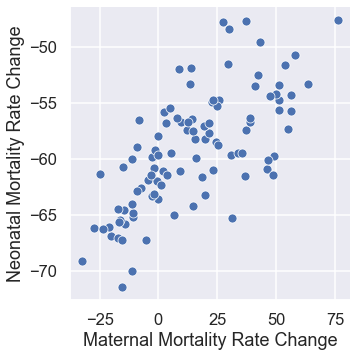

In [47]:
county_mortality_data = maternalChange.merge(neonatalChange, how='inner', on="Location")
fig1 = sns.relplot(data=county_mortality_data, x="% Change in Mortality Rate, 1980-2014_x", y="% Change in Mortality Rate, 1980-2014_y")
fig1.set_axis_labels('Maternal Mortality Rate Change', 'Neonatal Mortality Rate Change')

In [48]:
county_all_data = county_mortality_data.merge(percent, how='inner', left_on="Location", right_on='county')
county_all_data["Contraceptive Demand"] = 0
avg = county_all_data["Percentage of Women with Potential Demand"].mean()
std = county_all_data["Percentage of Women with Potential Demand"].std()
bottom_third = avg - (1*std)
top_third = avg + (1*std)
county_all_data.loc[(county_all_data["Percentage of Women with Potential Demand"] < bottom_third), 'Contraceptive Demand'] = "Below Average"
county_all_data.loc[(county_all_data["Percentage of Women with Potential Demand"] > top_third), 'Contraceptive Demand'] = "Above Average"
county_all_data.loc[(county_all_data["Contraceptive Demand"] == 0), 'Contraceptive Demand'] = "Average"

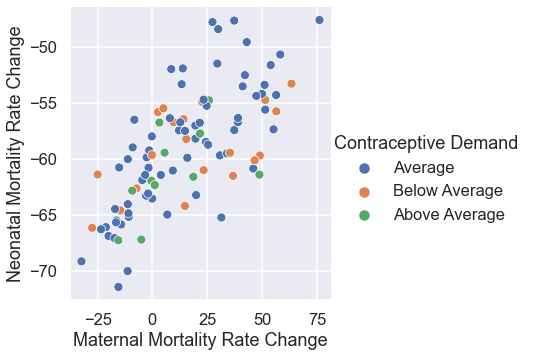

In [49]:
fig2 = sns.relplot(data=county_all_data, x="% Change in Mortality Rate, 1980-2014_x", y="% Change in Mortality Rate, 1980-2014_y", hue="Contraceptive Demand")
fig2.set_axis_labels('Maternal Mortality Rate Change', 'Neonatal Mortality Rate Change')

In [50]:
lunch = pd.read_csv("raw_data/ELSI.csv", header=3)
lunch = lunch.infer_objects()
lunches = lunch.drop(columns=["Total Number of Public Schools [Public School] 2017-18",
                              "Total Number of Public Schools [Public School] 2016-17",
                              "Total Number of Public Schools [Public School] 2015-16",
                              "Total Number of Public Schools [Public School] 2014-15",
                              "Free Lunch Eligible [Public School] 2017-18",
                              "Free Lunch Eligible [Public School] 2016-17",
                              "Free Lunch Eligible [Public School] 2015-16",
                              "Free Lunch Eligible [Public School] 2014-15",
                              "Reduced-price Lunch Eligible Students [Public School] 2017-18",
                              "Reduced-price Lunch Eligible Students [Public School] 2016-17",
                              "Reduced-price Lunch Eligible Students [Public School] 2015-16",
                              "Reduced-price Lunch Eligible Students [Public School] 2014-15",
                              "American Indian/Alaska Native Students [Public School] 2017-18",
                              "American Indian/Alaska Native Students [Public School] 2016-17",
                              "American Indian/Alaska Native Students [Public School] 2015-16",
                              "American Indian/Alaska Native Students [Public School] 2014-15",
                              "Asian or Asian/Pacific Islander Students [Public School] 2017-18",
                              "Asian or Asian/Pacific Islander Students [Public School] 2016-17",
                              "Asian or Asian/Pacific Islander Students [Public School] 2015-16",
                              "Asian or Asian/Pacific Islander Students [Public School] 2014-15",
                              "Hispanic Students [Public School] 2017-18",
                              "Hispanic Students [Public School] 2016-17",
                              "Hispanic Students [Public School] 2015-16",
                              "Hispanic Students [Public School] 2014-15",
                              "Black Students [Public School] 2017-18",
                              "Black Students [Public School] 2016-17",
                              "Black Students [Public School] 2015-16",
                              "Black Students [Public School] 2014-15",
                              "White Students [Public School] 2017-18",
                              "White Students [Public School] 2016-17",
                              "White Students [Public School] 2015-16",
                              "White Students [Public School] 2014-15",
                              "Hawaiian Nat./Pacific Isl. Students [Public School] 2017-18",
                              "Hawaiian Nat./Pacific Isl. Students [Public School] 2016-17",
                              "Hawaiian Nat./Pacific Isl. Students [Public School] 2015-16",
                              "Hawaiian Nat./Pacific Isl. Students [Public School] 2014-15",
                              "Two or More Races Students [Public School] 2017-18",
                              "Two or More Races Students [Public School] 2016-17",
                              "Two or More Races Students [Public School] 2015-16",
                              "Two or More Races Students [Public School] 2014-15",
                              "Total Race/Ethnicity [Public School] 2017-18",
                              "Total Race/Ethnicity [Public School] 2016-17",
                              "Total Race/Ethnicity [Public School] 2015-16",
                              "Total Race/Ethnicity [Public School] 2014-15"
                             ])
lunches = lunches.dropna()

r^2: -58.64061136480476


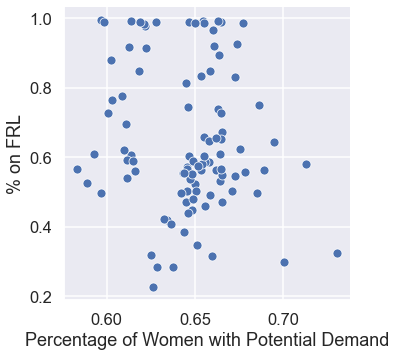

In [51]:
lunch_data = county_all_data.merge(lunches, how = 'inner', left_on = 'FIPS_x', right_on = "County Number [Public School] 2018-19")
lunch_data.loc[(lunch_data["Reduced-price Lunch Eligible Students [Public School] 2018-19"] == '="0"'), 'Reduced-price Lunch Eligible Students [Public School] 2018-19'] = '0'
lunch_data["Reduced-price Lunch Eligible Students [Public School] 2018-19"] = pd.to_numeric(lunch_data["Reduced-price Lunch Eligible Students [Public School] 2018-19"])
lunch_data["% on FRL"] = (lunch_data["Free Lunch Eligible [Public School] 2018-19"] + lunch_data["Reduced-price Lunch Eligible Students [Public School] 2018-19"]) / lunch_data["Total Race/Ethnicity [Public School] 2018-19"]

sns.relplot(data = lunch_data, x = "Percentage of Women with Potential Demand", y = "% on FRL")
print("r^2:", r2_score(lunch_data["Percentage of Women with Potential Demand"].values, lunch_data["% on FRL"].values))

r^2: -0.3270673089684739


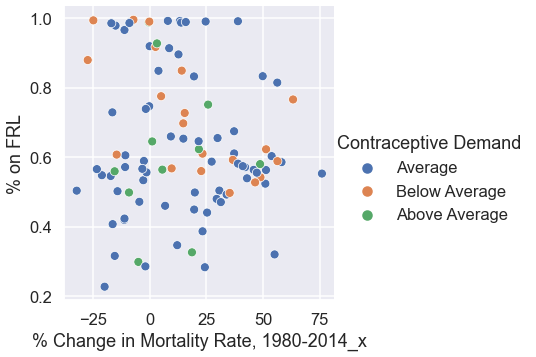

In [52]:
sns.relplot(data = lunch_data, x = "% Change in Mortality Rate, 1980-2014_x", y = "% on FRL", hue="Contraceptive Demand")
print("r^2:", r2_score(lunch_data["% Change in Mortality Rate, 1980-2014_x"].values, lunch_data["% on FRL"].values))

r^2: -133.57151045021664


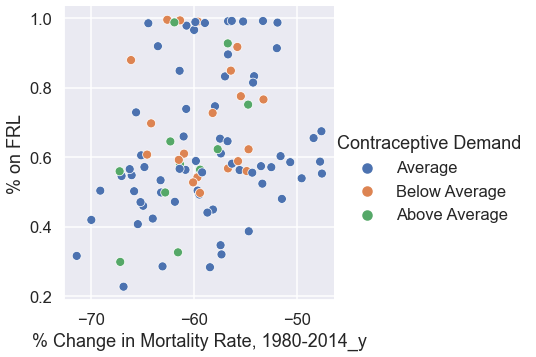

In [53]:
sns.relplot(data = lunch_data, x = "% Change in Mortality Rate, 1980-2014_y", y = "% on FRL", hue="Contraceptive Demand")
print("r^2:", r2_score(lunch_data["% Change in Mortality Rate, 1980-2014_y"].values, lunch_data["% on FRL"].values))

In [54]:
lunch_data

,Location,FIPS_x,Category_x,"% Change in Mortality Rate, 1980-2014_x",FIPS_y,Category_y,"% Change in Mortality Rate, 1980-2014_y",county,Total No of Women with potential demand for contraceptive services and supplies,Population of women aged 13-44,...,Reduced-price Lunch Eligible Students [Public School] 2018-19,American Indian/Alaska Native Students [Public School] 2018-19,Asian or Asian/Pacific Islander Students [Public School] 2018-19,Hispanic Students [Public School] 2018-19,Black Students [Public School] 2018-19,White Students [Public School] 2018-19,Hawaiian Nat./Pacific Isl. Students [Public School] 2018-19,Two or More Races Students [Public School] 2018-19,Total Race/Ethnicity [Public School] 2018-19,% on FRL
0,Alamance County,37001.0,Maternal disorders,51.35,37001.0,Neonatal disorders,-55.60,Alamance County,22110,33410,...,1073,85,377,6378.0,5439.0,11372.0,23,1196.0,24870.0,0.563008
1,Alexander County,37003.0,Maternal disorders,19.60,37003.0,Neonatal disorders,-58.19,Alexander County,4200,6480,...,254,5,75,496.0,188.0,3885.0,3,213.0,4865.0,0.449332
2,Alleghany County,37005.0,Maternal disorders,23.29,37005.0,Neonatal disorders,-61.00,Alleghany County,990,1670,...,128,4,3,338.0,8.0,1031.0,"=""0""",32.0,1416.0,0.610169
3,Anson County,37007.0,Maternal disorders,-8.23,37007.0,Neonatal disorders,-56.50,Anson County,2800,4460,...,0,9,54,179.0,1798.0,1015.0,1,119.0,3175.0,0.990236
4,Ashe County,37009.0,Maternal disorders,9.65,37009.0,Neonatal disorders,-56.73,Ashe County,2520,4320,...,301,3,18,376.0,11.0,2588.0,"=""0""",53.0,3049.0,0.567727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wayne County,37191.0,Maternal disorders,3.83,37191.0,Neonatal disorders,-61.43,Wayne County,16490,25040,...,100,35,233,4407.0,6994.0,6973.0,17,776.0,19435.0,0.848675
96,Wilkes County,37193.0,Maternal disorders,56.33,37193.0,Neonatal disorders,-54.29,Wilkes County,7770,12050,...,162,15,50,1405.0,357.0,7272.0,1,519.0,9619.0,0.814638
97,Wilson County,37195.0,Maternal disorders,-3.31,37195.0,Neonatal disorders,-61.43,Wilson County,10920,16430,...,219,32,168,2766.0,5902.0,3763.0,12,446.0,13089.0,0.566506
98,Yadkin County,37197.0,Maternal disorders,41.09,37197.0,Neonatal disorders,-53.52,Yadkin County,4380,6720,...,490,14,17,1370.0,157.0,3651.0,3,140.0,5352.0,0.574178


(array([0, 1, 2]),
 [Text(0, 0, 'Average'),
  Text(1, 0, 'Below Average'),
  Text(2, 0, 'Above Average')])

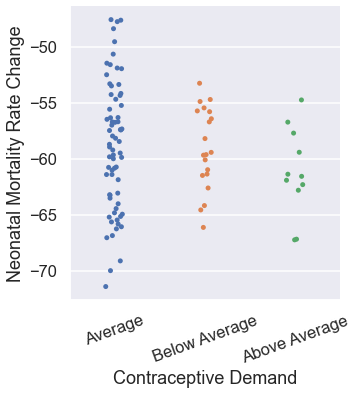

In [55]:
fig3 = sns.catplot(data=county_all_data, x="Contraceptive Demand", y="% Change in Mortality Rate, 1980-2014_y")
fig3.set_axis_labels('Contraceptive Demand', 'Neonatal Mortality Rate Change')
plt.xticks(rotation = 20)

(array([0, 1, 2]),
 [Text(0, 0, 'Average'),
  Text(1, 0, 'Below Average'),
  Text(2, 0, 'Above Average')])

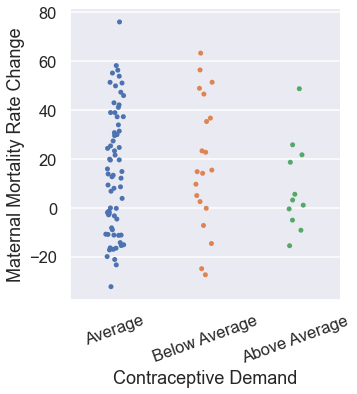

In [56]:
fig = sns.catplot(data=county_all_data, x='Contraceptive Demand', y='% Change in Mortality Rate, 1980-2014_x')
fig.set_axis_labels('Contraceptive Demand', 'Maternal Mortality Rate Change')
plt.xticks(rotation = 20)

In [57]:
lunch_data.dtypes

Location                                                                            object
FIPS_x                                                                             float64
Category_x                                                                          object
% Change in Mortality Rate, 1980-2014_x                                            float64
FIPS_y                                                                             float64
Category_y                                                                          object
% Change in Mortality Rate, 1980-2014_y                                            float64
county                                                                              object
Total No of Women with potential demand for contraceptive services and supplies      int64
Population of women aged 13-44                                                       int64
Percentage of Women with Potential Demand                                          float64

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix

lunch_data = np.append(OneHotEncoder().fit_transform(lunch_data[["Location", "Category_x", "Category_y",'American Indian/Alaska Native Students [Public School] 2018-19',
       'Asian or Asian/Pacific Islander Students [Public School] 2018-19','Hawaiian Nat./Pacific Isl. Students [Public School] 2018-19']].values).toarray(),lunch_data[['FIPS_x',
       '% Change in Mortality Rate, 1980-2014_x', 'FIPS_y',
       '% Change in Mortality Rate, 1980-2014_y',
       'Total No of Women with potential demand for contraceptive services and supplies',
       'Population of women aged 13-44',
       'Percentage of Women with Potential Demand',
       'County Name', 'County Number [Public School] 2018-19',
       'Total Number of Public Schools [Public School] 2018-19',
       'Free Lunch Eligible [Public School] 2018-19',
       'Reduced-price Lunch Eligible Students [Public School] 2018-19',
       'Hispanic Students [Public School] 2018-19',
       'Black Students [Public School] 2018-19',
       'White Students [Public School] 2018-19',
       'Two or More Races Students [Public School] 2018-19',
       'Total Race/Ethnicity [Public School] 2018-19', '% on FRL']], axis=1)

Y = OrdinalEncoder().fit_transform(lunch_data[["Contraceptive Demand"]].values)
#we split the dataset into a test and training set
train_x, test_x, train_y, test_y = train_test_split(X,Y , test_size=0.7, random_state=0)
clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
clf.fit(train_x, train_y)
clf.score(test_x, test_y)
metrics.plot_confusion_matrix(clf, test_x, test_y)
plt.grid(False)
print("Classification Accuracy:", clf.score(test_x, test_y))

<ipython-input-65-bb5369f4781e>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lunch_data = np.append(OneHotEncoder().fit_transform(lunch_data[["Location", "Category_x", "Category_y",'American Indian/Alaska Native Students [Public School] 2018-19',


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices